In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import altair as alt

alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype');

### Read Data

In [2]:
with open("config.yaml", "r") as config_file:
    config = yaml.full_load(config_file)
    data_path = config["data_path"]
    models_path = config["models_path"]

In [3]:
price_rank_df = pd.read_csv(os.path.join(data_path, "price_rank_data2.csv"))
price_rank_df.head(3)

,price,rank
0,2,7493.0
1,3,45263.0
2,4,43795.0


### Curve fitting

In [4]:
min_price, max_price = price_rank_df["price"].min(), price_rank_df["price"].max()
print(f"Min price: {min_price}\nMax price: {max_price}")

Min price: 2
Max price: 49


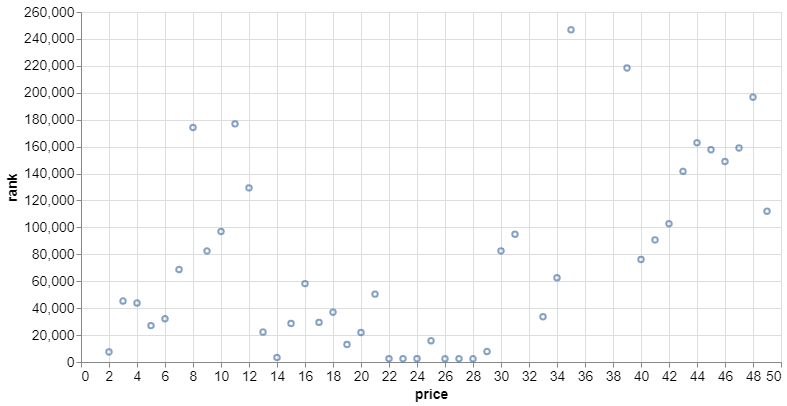

In [5]:
alt.Chart(price_rank_df).mark_point().encode(
    x=alt.X('price:Q', scale=alt.Scale(zero=False)),
    y=alt.Y('rank:Q', scale=alt.Scale(zero=False))
).properties(width=700, height=350).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)

In [6]:
degrees = range(1, 9)

for deg in degrees:
    coefficients = np.polyfit(price_rank_df["price"], price_rank_df["rank"], deg)
    polynom_fn = np.poly1d(coefficients)
    price_rank_df[f"polynom {deg} pred"] = polynom_fn(price_rank_df["price"])

price_rank_df.head(3)

,price,rank,polynom 1 pred,polynom 2 pred,polynom 3 pred,polynom 4 pred,polynom 5 pred,polynom 6 pred,polynom 7 pred,polynom 8 pred
0,2,7493.0,24275.707780,79134.929592,72061.543701,8485.101098,-18246.073353,-976.987828,16462.693073,8466.325653
1,3,45263.0,26497.189409,74316.044404,69097.173181,32799.136786,23255.394207,24882.816158,21408.653451,25718.180858
2,4,43795.0,28718.671038,69800.792948,66229.993234,51818.539204,54200.280341,47080.810625,35056.189933,42267.074100


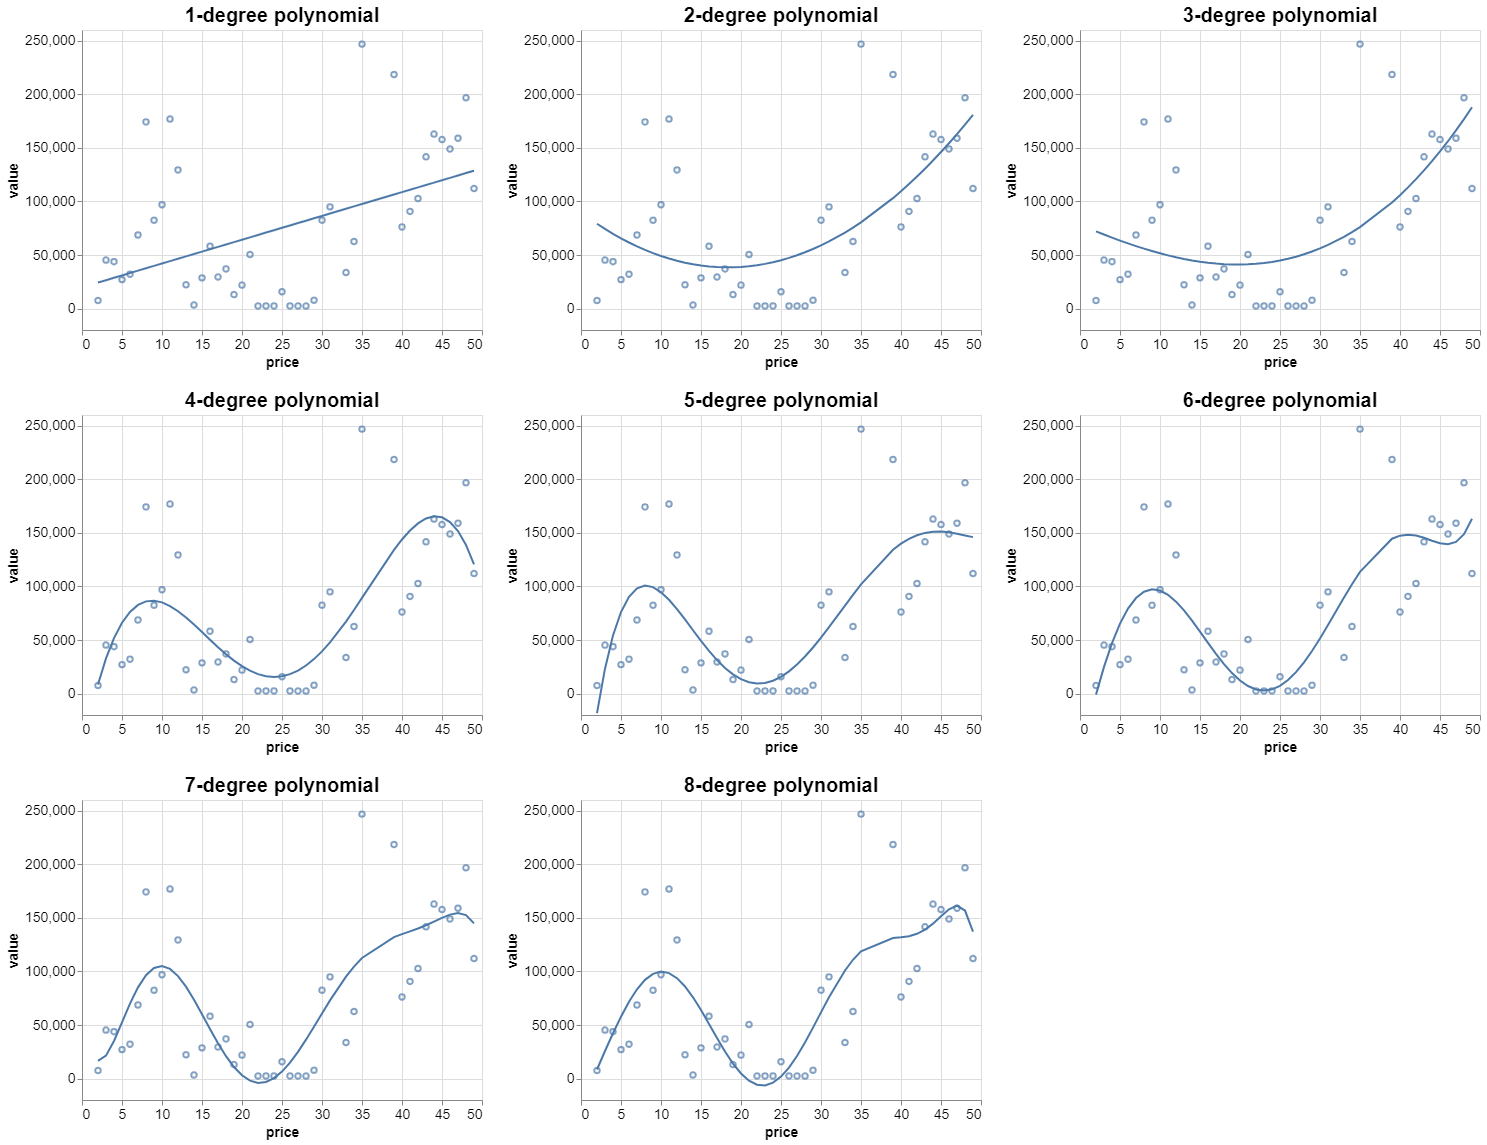

In [14]:
melted_df = pd.melt(price_rank_df, "price")

points_chart = alt.Chart(melted_df).transform_filter(alt.FieldEqualPredicate(field="variable", equal="rank")) \
.mark_point().encode(
    x=alt.X("price:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

curve_chart = alt.Chart(melted_df).mark_line().encode(
    x=alt.X("price:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      points_chart + curve_chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=f"polynom {deg} pred")).properties(title=f"{deg}-degree polynomial")
      for deg in degrees
    ],
    columns=3
).resolve_axis(
    x="shared",
    y="shared"
).resolve_scale(
    x="shared", 
    y="shared"
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

### Save coefficients

In [10]:
coefficients = np.polyfit(price_rank_df["price"], price_rank_df["rank"], 6)
coefficients

array([ 6.25934313e-04, -8.52756070e-02,  3.58595300e+00, -2.59940018e+01,
       -1.28454995e+03,  2.08376084e+04, -2.38392754e+04])

In [11]:
np.save(os.path.join(models_path, "price_rank_curve_coefficients.npy"), coefficients)